## 1. Setup & Data Loading

## 2. Preprocessin

In [1]:
# Preprocessing: Resize to 224x224, normalize, split train/test

import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
dataset_dir = "Dataset"
categories = ["Healthy", "Unhealthy"]
img_size = (224, 224)

# Load and preprocess images
data = []
labels = []

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    for fname in os.listdir(category_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(category_path, fname)
            img = Image.open(img_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize
            data.append(img_array)
            labels.append(label)

data = np.array(data)
labels = np.array(labels)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

Train samples: 320, Test samples: 80


## 3. Model Building

In [2]:
# Model Building: Transfer Learning with MobileNetV2

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Prepare data for Keras (add batch dimension)
X_train_tf = X_train.astype('float32')
X_test_tf = X_test.astype('float32')

# MobileNetV2 base (no top, pretrained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train for 2–3 epochs
history = model.fit(
    X_train_tf, y_train,
    validation_data=(X_test_tf, y_test),
    epochs=3,
    batch_size=32
)

# Evaluate
loss, acc = model.evaluate(X_test_tf, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 880ms/step - accuracy: 0.5906 - loss: 0.6708 - val_accuracy: 0.7750 - val_loss: 0.5259
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.8094 - loss: 0.4832 - val_accuracy: 0.9125 - val_loss: 0.3850
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 633ms/step - accuracy: 0.8719 - loss: 0.3790 - val_accuracy: 0.9000 - val_loss: 0.3143
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.9000 - loss: 0.3143
Test Accuracy: 0.9000


## 4. Evaluation

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  
Test Accuracy (sklearn): 0.9000


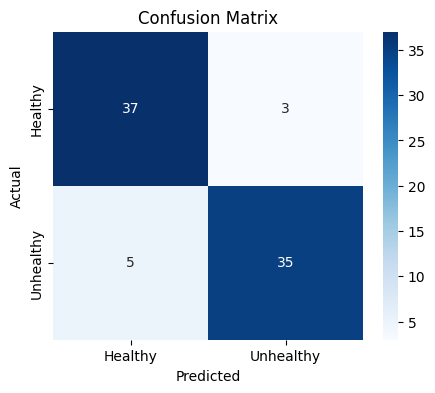

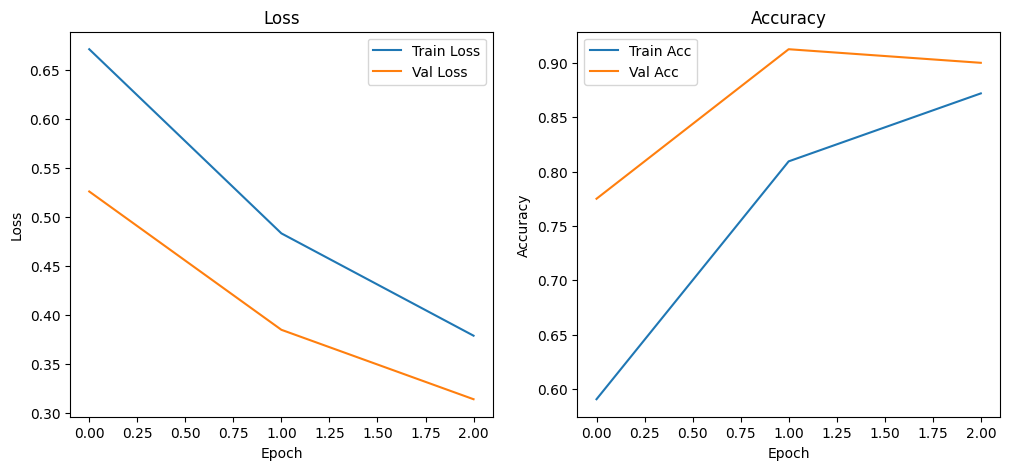

In [3]:
# Evaluation: Accuracy, Confusion Matrix, Plot Loss/Accuracy

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Predict on test set
y_pred_probs = model.predict(X_test_tf)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (sklearn): {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training vs validation loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

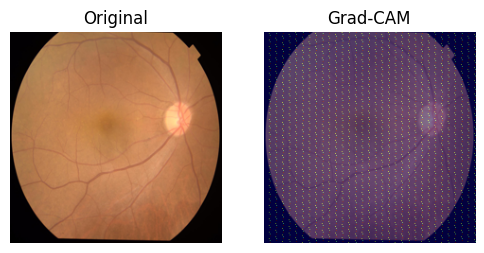

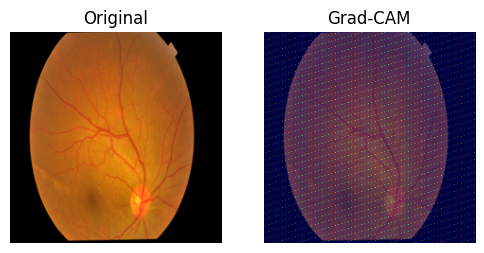

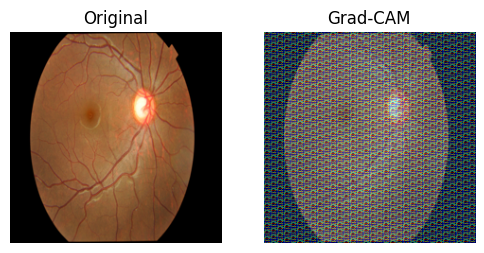

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def get_gradcam_heatmap(model, image, last_conv_layer_name):
    # Create a model that maps the input image to the activations
    # of the last conv layer and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[0]  # Use the full output for binary/multi-class
    
    grads = tape.gradient(loss, conv_outputs)[0]
    
    # Global average pooling to get weights
    weights = tf.reduce_mean(grads, axis=(0, 1))
    
    # Weighted combination of feature maps
    cam = np.dot(conv_outputs[0], weights.numpy())
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)  # Normalize
    cam = np.uint8(255 * cam)
    
    # Resize heatmap to image size
    cam = np.resize(cam, (224, 224))
    return cam

# Pick exactly 3 random test images
num_images = 3
indices = np.random.choice(len(X_test_tf), num_images, replace=False)
last_conv_layer_name = 'Conv_1'  # MobileNetV2 last conv layer

for idx in indices:
    img = X_test_tf[idx]
    heatmap = get_gradcam_heatmap(model, img, last_conv_layer_name)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title('Grad-CAM')
    plt.axis('off')
    
    plt.show()


In [5]:
# Save the trained model for later use in app.py
model.save("iris_disease_model.h5")
print("Model saved as iris_disease_model.h5")

Model saved as iris_disease_model.h5
